# Construction of the Extended Moral Foundations Dicitonary (e-MFD)


In this notebook, we show the steps applied to construct the e-MFD and encourage readers to read through the steps for enhanced clarity.

We begin with importing all packages that are relevant for this notebook.

***

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# NLP
import spacy, re, fnmatch 
nlp = spacy.load('en')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer

# Stopwords 
from nltk.corpus import stopwords
nltk_stopwords = stopwords.words('english')
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from spacy.lang.en.stop_words import STOP_WORDS

from multiprocessing import Pool

***

## Load and Preprocess Highlights

In the below cell, we load all raw highlights (`hl`) and only select highlights from coders that spent at least 45 minutes using the MoNA Platform. 

In [2]:
# Load Highlights
hl = pd.read_csv('data/highlights_raw.csv', index_col=0)
hl = hl[hl.focus_duration >= 45*60]
hl = hl[hl['coder_id']!= 549] #Excluded this person as their number of highlights exceeded the average number of highlights-per-coder by 2 standard deviations

In the following cells, we define all functions that are used to preprocess the raw highlight data.

In [3]:
def filter_hl(hl):
    
    '''Ensures that each document has been coded by at least two coders that differed in their assigned foundation'''
    
    grouped_doc = hl.groupby(hl.document_id).nunique()
    grouped_doc = grouped_doc[grouped_doc.assigned_domain >= 2]
    grouped_doc = grouped_doc[np.logical_and(grouped_doc.coder_id <= 15, grouped_doc.coder_id >= 2)] 
    
    keep_docs = grouped_doc.index.values
    hl = hl[hl.document_id.isin(keep_docs)]
    
    return hl

In [4]:
def remove_entities(hl):
    
    '''Removes any entity contained in highlights'''
    
    entities = []
    for doc in nlp.pipe(hl['content'].astype('unicode').values, disable=['tagger', 'parser','textcat'],
                        batch_size=500, n_threads=-1):
        entities.append(list(zip([ent.text for ent in doc.ents],[ent.label_ for ent in doc.ents])))
        
    entities = [ent for highlight in entities for ent in highlight]
    rem_entities = []
    for ent in entities:
        if ent[1] != 'PRODUCT' and len(ent[0]) >= 3:
            rem_entities.append(ent)  

    rem_entities = [x[0] for x in set(rem_entities)]
    rem_entities = [x.replace('(','') for x in rem_entities]
    rem_entities = [x.replace(')','') for x in rem_entities]
    
    hl['content'] = hl['content'].str.replace(')','')
    hl['content'] = hl['content'].str.replace('(','')

    for ent in rem_entities:
        pat = r"\b"+ ent + r"\b"
        hl['content'] = hl['content'].str.replace(pat,'') 
        
    return hl

In [5]:
def remove_punctuation(hl):
    
    '''Removes punctuations and extra whitespace contained in highlights'''
    
    from string import punctuation
    punctuation += '’'
    punctuation = punctuation.replace('\'','')
    punctuation = punctuation.replace('-','')
    for punct in punctuation:
        hl['content'] = hl['content'].str.replace(punct,'')

    hl['content'] = hl['content'].str.replace(r"\s+"," ")    
    
    return hl

In [6]:
def pos_tag_sentiment(hl):
    
    '''Performs part of speech tagging.
    Only certain POS are kept in the data (see keep_pos). 
    For a full tagging scheme, see https://spacy.io/api/annotation#pos-tagging 
    '''
    
    tokens = []
    pos = []
    tups = []

    for doc in nlp.pipe(hl['content'].astype('unicode').values, disable=['ner','textcat', 'parser'],
                        batch_size=500, n_threads=-1):    
        tokens.append([n.text for n in doc])
        pos.append([n.tag_ for n in doc])
        tups.append(list(zip([n.text for n in doc], [n.tag_ for n in doc])))
        
    hl['tups'] = tups

    # Define POS to keep and special characters to delete
    keep_pos = ['NN','NNS','JJ','VB','VBD','VBG','VBN','VBP','VBZ','RB']
    no_chars = ["…","'ve","'s","'ll","'d","\"","'m","'s","'re","–-",'–-', '‘', '’d', '’ll', '’m', '’re', '’s', '’ve',
                '“', ',,',',','(',')','.', '”', '\n\n',"@realDonaldTrump","n't",'\xad']

    hl['tokens'] = hl.tups.apply(lambda y: [x[0] for x in y if np.logical_and(x[0] not in no_chars, x[1] in keep_pos)])

    # Remove stopwords
    stopwords = set(list(nltk_stopwords) + list(ENGLISH_STOP_WORDS) + list(STOP_WORDS))
    hl['tokens'] = hl.tokens.apply(lambda y: [x for x in y if (x not in stopwords)]) 

    # Only keep words with min. three characters
    hl['tokens'] = hl.tokens.apply(lambda y: [x for x in y if (len(x) >= 3)]) 

    # Lowercase
    hl['tokens'] = hl.tokens.apply(lambda y: [x.lower() for x in y])

    hl['content'] = hl.tokens.apply(lambda x: ','.join(x))
    hl['content'] = hl.content.str.replace(',',' ')
    
    del hl['tups']
    
    #Sentiment analysis
    analyzer = SentimentIntensityAnalyzer()
    hl['vader'] = hl['content'].apply(lambda x: analyzer.polarity_scores(x)) 
    hl['comp'] = hl['vader'].apply(pd.Series)['compound']
    hl['pos'] = hl['vader'].apply(pd.Series)['pos']
    hl['neg'] = hl['vader'].apply(pd.Series)['neg']
    hl['neu'] = hl['vader'].apply(pd.Series)['neu']
    hl['sent_foundation'] = ''
    
    for i,row in hl.iterrows():
        if row.comp < 0.0:
            hl.at[i, 'sent_foundation'] = row.assigned_domain + '.vice'
        elif row.comp > 0.0:
            hl.at[i, 'sent_foundation'] = row.assigned_domain + '.virtue'
        elif row.comp == 0.0:
            hl.at[i, 'sent_foundation'] = row.assigned_domain + '.context'
            
    del hl['vader']
    
    return hl

def parallelize_dataframe(df, func):
    
    '''Simple function to multiprocess functions on dataframe.
    Adjust the Pool value to match your machine CPU capability'''
    
    df_split = np.array_split(df, 12)
    pool = Pool(12)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    
    return df

In [7]:
# Perform preprocessing by calling all functions 
print("Starting highlight preprocessing. This will take a few minutes.")
print('Total number of highlights in data before preprocessing:', len(hl))
filtered_hl = parallelize_dataframe(hl, filter_hl)
print("Number of highlights after filtering bad highlights and documents:", len(filtered_hl))
removed_entities = parallelize_dataframe(filtered_hl, remove_entities)
print("Removed entities from highlights.")
removed_punctuation = parallelize_dataframe(removed_entities, remove_punctuation)
print("Removed punctuations from highlights.")
hl = parallelize_dataframe(removed_punctuation, pos_tag_sentiment)
print("POS tagging completed.")

# Filter highlights that are longer than the 90th percentile of highlight length to minimize noise
hl['length'] = hl.tokens.apply(lambda x: len(x))
hl = hl[np.logical_and(hl.length >= 3, hl.length <= hl.length.quantile(0.90))] 
print('Highlight preprocessing completed.')
print("Total number of highlights in training data:", len(hl))
print('Total number of unique documents in data:', len(hl.document_id.unique()))
print('Total number of unique coders:', len(hl.coder_id.unique()))
hl.to_csv('data/highlights_preprocessed.csv', sep=';')

Starting highlight preprocessing. This will take a few minutes.
Total number of highlights in data before preprocessing: 63958
Number of highlights after filtering bad highlights and documents: 47639
Removed entities from highlights.
Removed punctuations from highlights.
POS tagging completed.
Highlight preprocessing completed.
Total number of highlights in training data: 35994
Total number of unique documents in data: 991
Total number of unique coders: 510


***

## Highlights Descriptives

In the following, we provide a few descriptives on the preprocessed `hl` data.

**How many coders coded a particular document with a particular foundation?**

Text(0.5, 1.0, 'Figure 1. Frequency Distribution of Coders and Assigned Foundations')

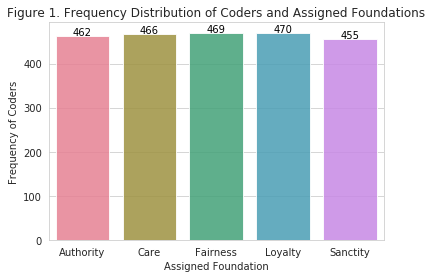

In [8]:
g=sns.barplot(x='assigned_domain', y='coder_id', data = hl.groupby('assigned_domain')['coder_id'].nunique().reset_index(), palette='husl', alpha=0.85)

for index, row in hl.groupby('assigned_domain')['coder_id'].nunique().reset_index().iterrows():
     g.text(x=index, y=row['coder_id']+2, s=row['coder_id'], color='black', ha="center")

plt.ylabel('Frequency of Coders')
labels = [item.get_text().capitalize() for item in g.get_xticklabels()]
g.set_xticklabels(labels)
plt.xlabel('Assigned Foundation')
plt.title('Figure 1. Frequency Distribution of Coders and Assigned Foundations')

**How many highlights have been genereated for each foundation?**

Text(0.5, 1.0, 'Figure 2. Frequency Distribution of Produced Annotations per Foundation')

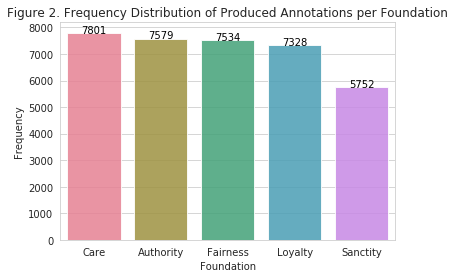

In [9]:
g=sns.countplot(hl.assigned_domain,  order=hl.assigned_domain.value_counts().index, palette='husl', alpha=0.85)

for index, row in pd.DataFrame(hl.assigned_domain.value_counts()).reset_index().iterrows():
     g.text(x=index, y=row['assigned_domain']+2, s=row['assigned_domain'], color='black', ha="center")

labels = [item.get_text().capitalize() for item in g.get_xticklabels()]
g.set_xticklabels(labels)
plt.ylabel("Frequency")
plt.xlabel("Foundation")
plt.title('Figure 2. Frequency Distribution of Produced Annotations per Foundation')

**Distribution of Highlight Length?**

Text(0.5, 1.0, 'Figure 3. Frequency Distribution of Annotation Length')

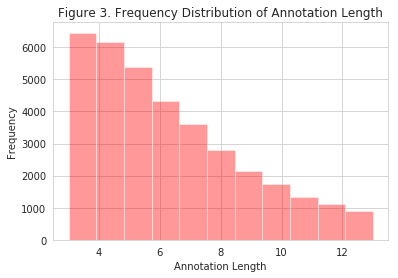

In [10]:
sns.distplot(hl['length'], color='r', bins=11, kde=False)
plt.xlabel('Annotation Length')
plt.ylabel('Frequency')
plt.title('Figure 3. Frequency Distribution of Annotation Length')

In [11]:
hl['length'].describe()[['mean','std']]

mean    6.141801
std     2.722377
Name: length, dtype: float64

**Length of highlights per coder?**

Text(0.5, 1.0, 'Figure 4. Average Annotation Lenght per Coder')

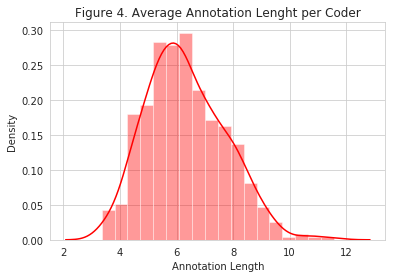

In [12]:
sns.distplot(hl.groupby(hl.coder_id)['length'].mean(), kde=True, color='r')
# plt.xlim(0,5,1)
plt.xlabel('Annotation Length')
plt.ylabel('Density')
plt.title('Figure 4. Average Annotation Lenght per Coder')

**How many coders have been assigned per document?**

Text(0.5, 1.0, 'Figure 5. Frequency Distribution of Coders per Document')

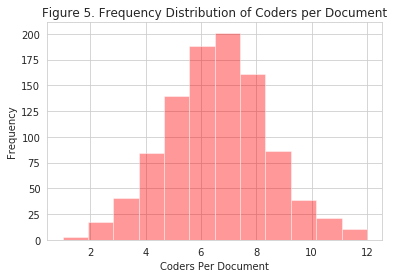

In [13]:
sns.distplot(hl.groupby(hl.document_id)['coder_id'].nunique(), kde=False, bins=12, color='r')
plt.xlabel('Coders Per Document')
plt.ylabel('Frequency')
plt.title('Figure 5. Frequency Distribution of Coders per Document')

In [14]:
hl.groupby(hl.document_id)['coder_id'].nunique().describe()[['mean','std']]

mean    6.593340
std     2.002805
Name: coder_id, dtype: float64

**How many foundations have been coded for each document?**

Text(0.5, 1.0, 'Figure 6. Frequency Distribution of Annotated Foundations per \n Document')

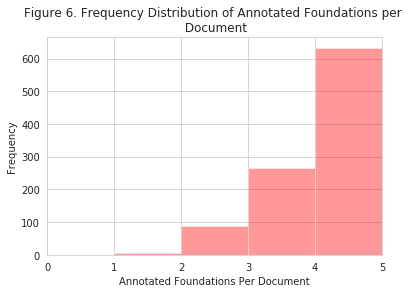

In [15]:
sns.distplot(hl.groupby(hl.document_id)['assigned_domain'].nunique(), kde=False, bins=4, color='r')
plt.xlim(0,5,1)
plt.xlabel('Annotated Foundations Per Document')
plt.ylabel('Frequency')
plt.title('Figure 6. Frequency Distribution of Annotated Foundations per \n Document')

In [16]:
hl.groupby(hl.document_id)['assigned_domain'].nunique().describe()[['mean','std']]

mean    3.742684
std     0.899711
Name: assigned_domain, dtype: float64

Text(0.5, 1.0, 'Figure 6. Distribution of Composite Sentiment')

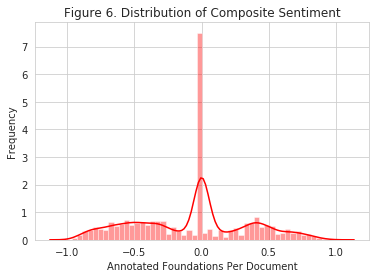

In [17]:
sns.distplot(hl['comp'], kde=True, color='r')
plt.xlabel('Annotated Foundations Per Document')
plt.ylabel('Frequency')
plt.title('Figure 6. Distribution of Composite Sentiment')

**Sentiment per Foundation**

Text(0.5, 1.0, 'Figure 7. Frequency Distribution of Coders and Assigned Foundations')

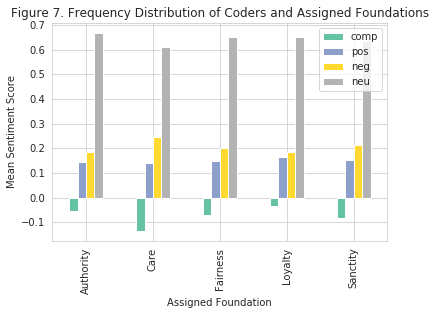

In [18]:
g=hl.groupby('assigned_domain')[['comp','pos','neg','neu']].mean().plot(kind='bar', colormap='Set2')
plt.ylabel('Mean Sentiment Score')
labels = [item.get_text().capitalize() for item in g.get_xticklabels()]
g.set_xticklabels(labels)
plt.xlabel('Assigned Foundation')
plt.title('Figure 7. Frequency Distribution of Coders and Assigned Foundations')

**How many highlights when considering sentiment?**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

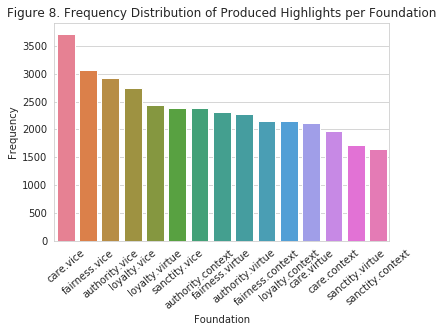

In [19]:
sns.countplot(hl.sent_foundation,  order=hl.sent_foundation.value_counts().index, palette='husl')
plt.ylabel("Frequency")
plt.xlabel("Foundation")
plt.title('Figure 8. Frequency Distribution of Produced Highlights per Foundation')
plt.xticks(rotation=40)

***

## Construct Vocabulary

In the following steps, we construct the `vocabulary`. This vocabulary is a DataFrame that is indexed by each unique word that is found in the processed `hl`.

In [20]:
tokens = [token for highlight in hl.tokens.values for token in highlight]
print('Total number of words in highlights:', len(tokens))

Total number of words in highlights: 221068


In [21]:
vocab = set(tokens)
vocab = [x.lower() for x in vocab]
vocab = [x for x in vocab if len(x) >= 3]

stopwords = set(list(nltk_stopwords) + list(ENGLISH_STOP_WORDS) + list(STOP_WORDS))
vocab = [x for x in vocab if x not in stopwords]

vocab = pd.DataFrame(vocab)
vocab = vocab.rename(columns={0:'word'})

# Remove words with numbers 
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def hasPunct(inputString):
    if any(char in punctuation for char in inputString):
        return 'True'
    else:
        return 'False'

vocab['has_number'] = vocab.word.apply(lambda x: hasNumbers(x))
vocab['has_punct'] = vocab.word.apply(lambda x: hasPunct(x))

vocab = vocab[np.logical_and(vocab['has_number']==False, vocab['has_punct']=='False')]

del vocab['has_number']
del vocab['has_punct']

base_founds = ['care','fairness','loyalty','authority','sanctity']
    
for f in base_founds:
    vocab[str(f)+'_hlcts'] = 0.0

vocab.index = vocab.word

print('Final vocabulary size after preprocessing:', len(vocab))

Final vocabulary size after preprocessing: 15962


In [22]:
vocab.head()

,word,care_hlcts,fairness_hlcts,loyalty_hlcts,authority_hlcts,sanctity_hlcts
word,,,,,,
piece,piece,0.0,0.0,0.0,0.0,0.0
characteristically,characteristically,0.0,0.0,0.0,0.0,0.0
skull,skull,0.0,0.0,0.0,0.0,0.0
rejects,rejects,0.0,0.0,0.0,0.0,0.0
generations,generations,0.0,0.0,0.0,0.0,0.0


### How many times has a word in the vocabulary been seen by (a) ALL coders and (b) by coders with a certain foundation?

#### 1) How often does each word appear in each document

In the cell below, we read in all the news articles that were seen and coded by the human coders. We then preprocess the document text by removing punctuations and stopwords. In a final step, we compute the frequency with which each word appeared in each document.

In [23]:
# Get the documents
hl_docs = pd.read_pickle('data/coded_news.pkl')
corpus = hl_docs[hl_docs.index.isin(hl.document_id)]
corpus['text'] = corpus['text'].str.lower()

def preprocess(text):
    raw_text = text
    for s in punctuation:
        raw_text = raw_text.replace(s,'')
    for s in stopwords:
        regex = re.compile(r"\b{}\b".format(s))
        raw_text = re.sub(regex, '', raw_text)
    raw_text = raw_text.replace('\'','')
    raw_text = raw_text.strip()
    raw_text = " ".join(raw_text.split())
    return raw_text

corpus['text'] = corpus['text'].apply(lambda x:preprocess(x))

# Calculate term frequency
vec = CountVectorizer(stop_words=stopwords)
X = vec.fit_transform(corpus['text'])
word_per_doc = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
word_per_doc.index = corpus.index
word_per_doc = word_per_doc.T
word_per_doc = word_per_doc.reset_index().rename(columns={'index':'word'})
word_per_doc = word_per_doc[word_per_doc.word.isin(vocab.word)]
word_per_doc = word_per_doc.set_index('word').T
word_per_doc = word_per_doc.fillna(0)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The result is a D x W matrix where D = number of unique documents and W = number of unique words. Each cell in that matrix captures how often that word appeared in that document.

In [24]:
word_per_doc.head()

word,aback,abandon,abandoned,abandoning,abandonment,abdication,abdomen,abducted,abducting,abducts,abeed,abetted,abetting,abhorrent,abhorrently,abide,abided,abiding,ability,abjure,able,abnormal,abnormalities,aboard,abolish,...,yields,yogurt,yoke,young,youngsters,youth,youthful,youths,yuan,zany,zeal,zealots,zealous,zealously,zenith,zeroed,zinc,zingers,zombies,zone,zoned,zones,zoning,zoo,zooming
4877,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4881,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4887,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4890,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 2) How many coders saw each document?

In the following, we determine the total number of coders that have seen each document (see the `total_seen` column on the right in the below table).

In [25]:
coders_per_doc = hl.groupby('document_id')['coder_id'].nunique()
coders_per_doc = coders_per_doc.fillna(0)

In [26]:
# Join these and multiply these with the above raw counts to get the total_seen variable 
total_seen = word_per_doc.join(coders_per_doc.rename('total_seen'))
total_seen[[c for c in total_seen.columns if c != 'total_seen']] = total_seen[[c for c in total_seen.columns if c != 'total_seen']].multiply(total_seen['total_seen'], axis=0)

In [27]:
total_seen.head()

,aback,abandon,abandoned,abandoning,abandonment,abdication,abdomen,abducted,abducting,abducts,abeed,abetted,abetting,abhorrent,abhorrently,abide,abided,abiding,ability,abjure,able,abnormal,abnormalities,aboard,abolish,...,yogurt,yoke,young,youngsters,youth,youthful,youths,yuan,zany,zeal,zealots,zealous,zealously,zenith,zeroed,zinc,zingers,zombies,zone,zoned,zones,zoning,zoo,zooming,total_seen
4877,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
4879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
4881,0,0,9,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
4887,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
4890,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [28]:
# Now, get the column sum to obtain total number of times this word was seen by coders across documents and add that variable to the vocabulary
vocab = vocab.join(total_seen[[c for c in total_seen.columns if c != 'total_seen']].sum().rename('total_seen'))

#### 3) How often was each word seen by coders with a given foundation?

Next up, we determine how often each word has been seen by a coder with a certain assigned foundation.

In [29]:
# Every unique coder is assigned a foundation per document 
# Question: for each document, get mapping of coder_id and assigned foundation 

# Make dataframe that is indexed by each document id
# Loop over each document and get the coders and their assigned foundation 
seen_by_foundation = pd.DataFrame(index=corpus.index, columns=['seen_care', 'seen_fairness','seen_loyalty','seen_authority','seen_sanctity'])

In [30]:
seen_by_foundation.head()

,seen_care,seen_fairness,seen_loyalty,seen_authority,seen_sanctity
4877,NaN,NaN,NaN,NaN,NaN
4879,NaN,NaN,NaN,NaN,NaN
4881,NaN,NaN,NaN,NaN,NaN
4887,NaN,NaN,NaN,NaN,NaN
4890,NaN,NaN,NaN,NaN,NaN


In [31]:
# In a first step, loop over the unique documents
doc_ids = seen_by_foundation.index.unique()
for doc_id in doc_ids:
    # Select all the hls that correspond to that doc_id
    document = hl[hl['document_id'] == doc_id]
    # Obtain the unique coder_ids per document and their assigned foundations
    coders_foundation = document.groupby('assigned_domain')['coder_id'].nunique()
    # Join these counts with the seen_by_foundation dataframe
    try:
        seen_by_foundation.at[doc_id, 'seen_care'] = coders_foundation.care
    except:
        pass
    try:
        seen_by_foundation.at[doc_id, 'seen_fairness'] = coders_foundation.fairness
    except:
        pass
    try:
        seen_by_foundation.at[doc_id, 'seen_loyalty'] = coders_foundation.loyalty
    except:
        pass
    try:
        seen_by_foundation.at[doc_id, 'seen_authority'] = coders_foundation.authority
    except:
        pass
    try:
        seen_by_foundation.at[doc_id, 'seen_sanctity'] = coders_foundation.sanctity
    except:
        pass

In [32]:
seen_by_foundation = seen_by_foundation.fillna(0)

In [33]:
seen_by_foundation.head()

,seen_care,seen_fairness,seen_loyalty,seen_authority,seen_sanctity
4877,0,2,1,2,2
4879,1,1,2,2,0
4881,2,3,1,0,3
4887,2,2,2,1,1
4890,1,0,0,0,2


So, document 4877 was coded by 2 fairness coders, 1 loyalty, 2 authority, and 2 sanctity coders.

In [34]:
# Join the coders per foundation with the word counts per document
seen_by_foundation = seen_by_foundation.join(word_per_doc)

In [35]:
seen_by_foundation.head()

,seen_care,seen_fairness,seen_loyalty,seen_authority,seen_sanctity,aback,abandon,abandoned,abandoning,abandonment,abdication,abdomen,abducted,abducting,abducts,abeed,abetted,abetting,abhorrent,abhorrently,abide,abided,abiding,ability,abjure,...,yields,yogurt,yoke,young,youngsters,youth,youthful,youths,yuan,zany,zeal,zealots,zealous,zealously,zenith,zeroed,zinc,zingers,zombies,zone,zoned,zones,zoning,zoo,zooming
4877,0,2,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4879,1,1,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4881,2,3,1,0,3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4887,2,2,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4890,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
seen_cols = [c for c in seen_by_foundation.columns if c.startswith('seen_')]

In [37]:
# Multiply each word count by the total sum of foundation-coders that saw this word
for seen_f in seen_cols:
    word_seen_vec = pd.DataFrame(seen_by_foundation[[seen_f]+[c for c in seen_by_foundation.columns if not c.startswith('seen_')]][[c for c in seen_by_foundation.columns if not c.startswith('seen_')]].apply(lambda x: x * seen_by_foundation[seen_f]).sum().rename(seen_f))
    vocab = vocab.join(word_seen_vec)

In [38]:
vocab.head()

,word,care_hlcts,fairness_hlcts,loyalty_hlcts,authority_hlcts,sanctity_hlcts,total_seen,seen_care,seen_fairness,seen_loyalty,seen_authority,seen_sanctity
word,,,,,,,,,,,,
piece,piece,0.0,0.0,0.0,0.0,0.0,397.0,77.0,86.0,90.0,72.0,72.0
characteristically,characteristically,0.0,0.0,0.0,0.0,0.0,6.0,0.0,3.0,2.0,0.0,1.0
skull,skull,0.0,0.0,0.0,0.0,0.0,21.0,6.0,6.0,2.0,4.0,3.0
rejects,rejects,0.0,0.0,0.0,0.0,0.0,42.0,13.0,9.0,10.0,5.0,5.0
generations,generations,0.0,0.0,0.0,0.0,0.0,209.0,52.0,35.0,56.0,45.0,21.0


As can be seen from the above vocabulary, we now know that the word `wrongdoing` was seen a total of 76 times across all coders.

In [39]:
vocab = vocab.dropna(subset=['total_seen'])
vocab = vocab[vocab.total_seen > 0]

### 4) Score Vocabulary

As a first step in scoring the vocabulary, we iterate over all highlights. Once a word is found in the vocabulary, we first obtain the foundation of the highlight where this word was mentioned. Then, in the vocabulary, we go to the column that reflects this foundation and increment a `1`. By doing so, we create a vocabulary that reflects how often a certain word appeared in highlights with a certain foundation.

In [40]:
# Add columns to store sentiments of highlights
for f in base_founds:
    vocab[f+'_pos'] = 0.0
    vocab[f+'_neg'] = 0.0
    vocab[f+'_neu'] = 0.0
    vocab[f+'_sent'] = 0.0 
    
vocab['avg_pos'] = 0.0
vocab['avg_neg'] = 0.0
vocab['avg_neu'] = 0.0

In [41]:
# Iterate over each word in each highlight and increment foundation counts
# Transform vocab into dictionary for faster hash functionality
words = {k:0.0 for k in vocab.index} 

for i,row in hl.iterrows():

    highlight = row.tokens
    base_found = row.assigned_domain

    pos = row.pos
    neg = row.neg
    neu = row.neu
    comp = row.comp
    
    for word in highlight:
        if word in words.keys():
            vocab.at[str(word),base_found+'_hlcts'] += 1
            vocab.at[str(word),base_found+'_pos'] += pos
            vocab.at[str(word),base_found+'_neg'] += neg
            vocab.at[str(word),base_found+'_neu'] += neu
            vocab.at[str(word),base_found+'_sent'] += comp

vocab['sum_hl'] = vocab[[c for c in vocab.columns if c.endswith('hlcts')]].sum(axis=1)
vocab = vocab.fillna(0)

In [42]:
vocab = vocab[vocab.sum_hl > 0]

### 5) Divide highlight counts by seen_by Columns

In the next step, we divide the total frequency a word has been highlighted with a certain foundation by the number of times this word has been seen by coders who were assigned that foundation. Doing so yields us a probabality that a word was highlighted by a coder. As an example, if the word `kill` has .8 in the Care_norm column, then this means that there is a 80% probability that `kill` was highlighted by a coder assigned the Care foundation.

In [43]:
# Create Probability columns 
for f in base_founds:
    vocab[f+'_p'] = 0.0
    
for i,row in vocab.iterrows():
    if row.seen_care != 0:
        vocab.at[i, 'care_p'] = row['care_hlcts'] / row.seen_care
        
    if row.seen_fairness != 0:
        vocab.at[i, 'fairness_p'] = row['fairness_hlcts'] / row.seen_fairness
   
    if row.seen_authority != 0:
        vocab.at[i, 'authority_p'] = row['authority_hlcts'] / row.seen_authority

    if row.seen_loyalty != 0:
        vocab.at[i, 'loyalty_p'] = row['loyalty_hlcts'] / row.seen_loyalty
        
    if row.seen_sanctity != 0:
        vocab.at[i, 'sanctity_p'] = row['sanctity_hlcts'] / row.seen_sanctity

In [44]:
# Remove words whose probabilities are above 1 for any given foundation (caused by minor preprocessing glitches)
probabilities = [c for c in vocab.columns if c.endswith('_p')]
vocab = vocab.iloc[pd.np.where(vocab[probabilities].le(1).all(1, skipna=True))]

In [45]:
print('Total number in vocabulary:',len(vocab))

Total number in vocabulary: 15785


In [46]:
# Ensure each word has been seen at least 10 times by any foundation coder
vocab = vocab[(vocab['seen_care'] > 10) & (vocab['seen_fairness'] > 10) & (vocab['seen_loyalty'] > 10) & (vocab['seen_authority'] > 10) & (vocab['seen_sanctity'] > 10)] 

In [47]:
print('Total number in vocabulary:',len(vocab))

Total number in vocabulary: 4688


In [48]:
# Ensure each word has been highlighted at least 5 times with any foundation
vocab = vocab.iloc[pd.np.where(vocab[[c for c in vocab.columns if c.endswith('_hlcts')]].ge(5).any(1, skipna=True))]

In [49]:
print('Total number in vocabulary:',len(vocab))

Total number in vocabulary: 3275


In [50]:
# Divide sentiment columns by hlcts to obtain average sentiment scores
for i,row in vocab.iterrows():
    if row.care_hlcts != 0:
        vocab.at[i, 'care_pos'] = row['care_pos'] / row.care_hlcts
        vocab.at[i, 'care_neg'] = row['care_neg'] / row.care_hlcts
        vocab.at[i, 'care_neu'] = row['care_neu'] / row.care_hlcts
        vocab.at[i, 'care_sent'] = row['care_sent'] / row.care_hlcts
        
    if row.fairness_hlcts != 0:
        vocab.at[i, 'fairness_pos'] = row['fairness_pos'] / row.fairness_hlcts
        vocab.at[i, 'fairness_neg'] = row['fairness_neg'] / row.fairness_hlcts
        vocab.at[i, 'fairness_neu'] = row['fairness_neu'] / row.fairness_hlcts
        vocab.at[i, 'fairness_sent'] = row['fairness_sent'] / row.fairness_hlcts
        
    if row.loyalty_hlcts != 0:
        vocab.at[i, 'loyalty_pos'] = row['loyalty_pos'] / row.loyalty_hlcts
        vocab.at[i, 'loyalty_neg'] = row['loyalty_neg'] / row.loyalty_hlcts
        vocab.at[i, 'loyalty_neu'] = row['loyalty_neu'] / row.loyalty_hlcts
        vocab.at[i, 'loyalty_sent'] = row['loyalty_sent'] / row.loyalty_hlcts
        
    if row.authority_hlcts != 0:
        vocab.at[i, 'authority_pos'] = row['authority_pos'] / row.authority_hlcts
        vocab.at[i, 'authority_neg'] = row['authority_neg'] / row.authority_hlcts
        vocab.at[i, 'authority_neu'] = row['authority_neu'] / row.authority_hlcts
        vocab.at[i, 'authority_sent'] = row['authority_sent'] / row.authority_hlcts
        
    if row.sanctity_hlcts != 0:
        vocab.at[i, 'sanctity_pos'] = row['sanctity_pos'] / row.sanctity_hlcts
        vocab.at[i, 'sanctity_neg'] = row['sanctity_neg'] / row.sanctity_hlcts
        vocab.at[i, 'sanctity_neu'] = row['sanctity_neu'] / row.sanctity_hlcts
        vocab.at[i, 'sanctity_sent'] = row['sanctity_sent'] / row.sanctity_hlcts

In [51]:
vocab = vocab.fillna(0)

In [52]:
vocab.to_pickle('dictionaries/emfd_full.pkl')

In [53]:
sent_cols = [c for c in vocab.columns if c.endswith('_sent')]

In [54]:
vocab[probabilities+sent_cols].to_pickle('dictionaries/emfd_scoring.pkl')

***

## Create Context-Free E-MFD

In [55]:
# Score Sentiment of each unique word with VADER
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
vocab['ind_vader'] = vocab.word.apply(lambda x: analyzer.polarity_scores(x)) 
vocab['ind_comp'] = vocab['ind_vader'].apply(pd.Series)['compound']

Add most likely POS tag for each word:

In [56]:
import nltk 
from nltk.corpus import brown

In [57]:
fd = nltk.FreqDist(brown.words())
cfd = nltk.ConditionalFreqDist(brown.tagged_words())
most_freq_words = fd.most_common()
likely_tags = dict((word, cfd[word].max()) for (word, _) in most_freq_words)
baseline_tagger = nltk.UnigramTagger(model=likely_tags)

In [58]:
vocab['tag'] = vocab['word'].apply(lambda x: baseline_tagger.tag([x]))
vocab['tag'] = vocab['tag'].apply(lambda y: [x[1] for x in y])

for i,row in vocab.iterrows():
    if row.tag[0] == None:
        vocab.at[i, 'tag'] = 'None'

vocab['tag'] = vocab['tag'].apply(lambda y: y[0])

for i,row in vocab.iterrows():
    if row.tag == 'NN' or row.tag == 'NNS':
        vocab.at[i, 'tag'] = 'n'
    if row.tag == 'VBN' or row.tag == 'VBZ' or row.tag == 'VBD' or row.tag == 'VB' or row.tag == 'VBG':
        vocab.at[i, 'tag'] = 'v'PAT extraction
    if row.tag == 'JJ':
        vocab.at[i, 'tag'] = 'a'
    if row.tag == 'RB':
        vocab.at[i, 'tag'] = 'r'
    if row.tag == 'N':
        vocab.at[i, 'tag'] = 'n'
        
pos_tags = ['n','v','a','r']
vocab = vocab[vocab.tag.isin(pos_tags)]

Delete words with neutral sentiment and create dictionary for context-indpendent use cases such as Affect Misattribution Procedures or Lexical Decision Tasks.

In [59]:
amp = vocab[vocab['ind_comp'] != 0]

In [60]:
print('Size of E-MFD with neutral words removed:', len(amp))

Size of E-MFD with neutral words removed: 688


In [61]:
amp.to_pickle('dictionaries/emfd_amp.pkl')